In [37]:
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get

import itertools
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 600)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm, tree
from sklearn.ensemble import RandomForestRegressor
from  sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
#import swifter

np.random.seed(1907)

In [4]:
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

#tqdm.pandas()

In [11]:
def initial_data_preparation():
    
    try:
        data = pd.read_csv("survey_results_public.csv")
        print("Data loaded locally.")
    except:
        data = pd.read_csv(r"https://raw.githubusercontent.com/ahmetsirel/ozu_data_science/master/DS%20555%20-%20Data%20Science%20%26%20Strategy/Project/survey_results_public.csv")
        print("Data loaded from github.")
    
    
    print(f"{len(data)} Rows.")

    # Numeric columns
    data[f"Age1stCode"] = data["Age1stCode"].replace('Younger than 5 years', "3").replace('Older than 85', "90").astype(float)
    data["YearsCode"] = data["YearsCode"].replace('Less than 1 year', "0.5").replace('More than 50 years', "55").astype(float)
    data["YearsCodePro"] = data["YearsCodePro"].replace('Less than 1 year', "0.5").replace('More than 50 years', "55").astype(float)

    # Drop unnecessary columns
    columns_to_drop = ["CurrencySymbol", "CompFreq", "CurrencyDesc", "CompTotal", "Respondent"]
    data = data.drop(columns_to_drop, axis=1)

    # Process multi choise columns
    def get_all_distinct_choices(column_name):
        list_of_choices = [str(item).split(";") for item in data[column_name].unique()]
        all_choices = []
        for ch in list_of_choices:
            all_choices += ch

        all_choices.remove("nan")
        all_choices = pd.Series(all_choices).unique().tolist()
        return all_choices

    def detect_multi_choise(column):
        return column.str.contains(";").sum() > 0

    is_multi_choice = data.loc[:, data.dtypes == "object"].apply(detect_multi_choise)
    multi_choice_columns = is_multi_choice[is_multi_choice].index.to_list()

    distinct_choice_lists_for_each_columns = {column: get_all_distinct_choices(column) for column in multi_choice_columns}

    def sep_multi_choice(row):
        #if int(row.name) % 5 ==0:
        #print(round((int(row.name) / len(data)),2))

        for column in multi_choice_columns:
            for choise in distinct_choice_lists_for_each_columns[column]:
                if type(row[column]) is str:
                    if  choise in row[column]:
                        row[column + "_" + choise] = 1
                    else:
                        row[column + "_" + choise] = 0
 
        return row

    try:
        data = pd.read_csv("data_prepared_temp_after_apply.csv")     
    except Exception as e:
        print(e)
        print("Multi choice columns processing is started.")
        #ddata = dd.from_pandas(data, npartitions=32)
        #data = ddata.map_partitions(lambda df: data.apply(sep_multi_choice, axis=1)).compute(get=get) 
        data = data.apply(sep_multi_choice, axis=1)
        print("Multi choice columns processed.")
    data = data.drop(multi_choice_columns, axis=1)
    
    
    # One hot encoding
    cat_columns = ["Country", "Gender", "JobSat", "JobSeek",
                                        "Employment",
                                        "MainBranch", 
                                        "Hobbyist", 
                                        "EdLevel", 
                                        "NEWDevOps", 
                                        "NEWDevOpsImpt", 
                                        "NEWEdImpt", 
                                        "NEWLearn",
                                        "NEWOffTopic",
                                        "NEWOnboardGood",
                                        "NEWOtherComms",
                                        "NEWOvertime",
                                        "NEWPurpleLink","OpSys","OrgSize",
                                        "PurchaseWhat","SOAccount",
                                        "SOComm","SOPartFreq","SOVisitFreq",
                                        "SurveyEase", "SurveyLength","Trans", "UndergradMajor","WelcomeChange"]
    cat_columns = [col for col in cat_columns if col not in multi_choice_columns]
    data = pd.get_dummies(data=data, columns=cat_columns)

    
    data = data.dropna(subset=["ConvertedComp"], axis=0)
    # Fill NaNs with mean
    nas = data.isna().sum()
    nas = nas[nas > 0]

    for na_col in nas.index:
        data[na_col].fillna(data[na_col].mean(), inplace=True)

    #LABEL :"ConvertedComp"
    return data

In [12]:
data = initial_data_preparation()
data.to_csv("data_prepared.csv",index=False)


Data loaded locally.
64461 Rows.


## TODO
- How many technologies he/she would like to learn? (DatabaseDesireNextYear, LanguageDesireNextYear) - Erdem
- How many technologies was used in the past? (DatabaseWorkedWith, LanguageWorkedWith) - Erdem
- Interaction between Job Satisfaction & Job Seeking columns and their impact on  compansation - Berk
- New Job Hunt:Better Comp. & Job Seeking. - Berk
- Target Encoding - Coutry, Tech, Currency  - Erdem

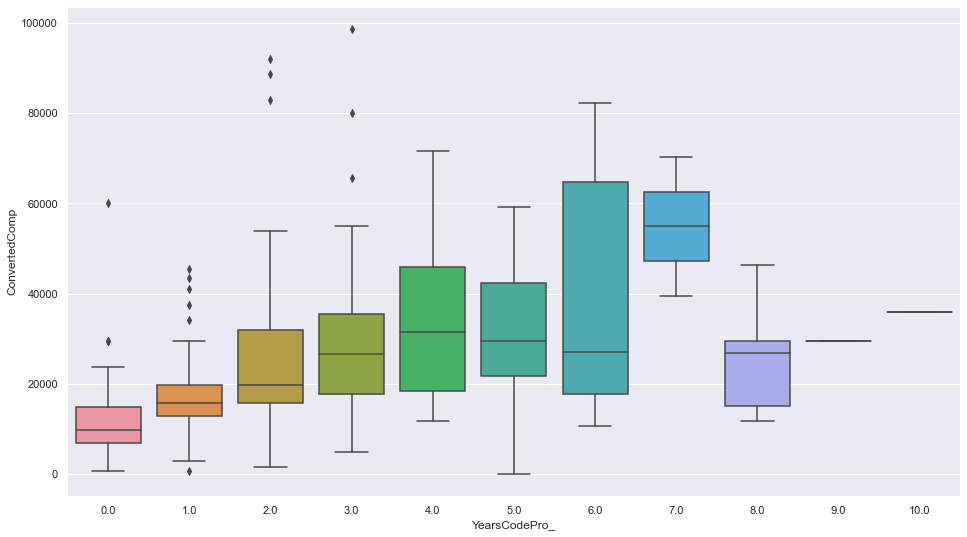

In [77]:
a = data[["ConvertedComp", "YearsCodePro", "Country_Turkey"]].sample(frac=1).reset_index(drop=True)
a = a[a["Country_Turkey"] == 1]
a = a[a.ConvertedComp <= 100000]
def year_div_10(row):
    row["YearsCodePro_"] = int(row["YearsCodePro"]/3)
    return row
sns.boxplot(x="YearsCodePro_", y="ConvertedComp", data=a.apply(year_div_10, axis=1))

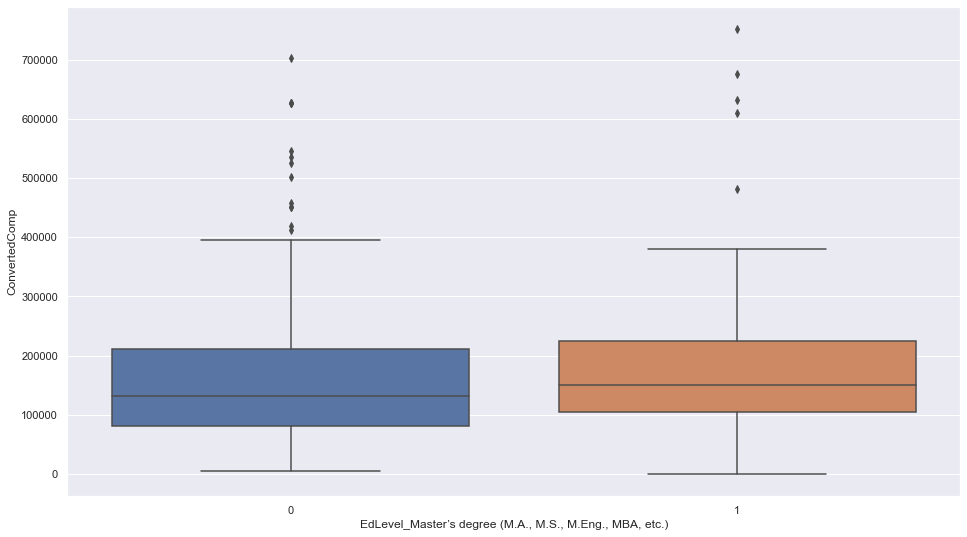

In [79]:
a = data[["ConvertedComp", "EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)", "Country_Turkey"]].sample(frac=1).reset_index(drop=True)
a = a[a["Country_Turkey"] == 1]
a = a[a.ConvertedComp <= 100000]
a["ConvertedComp"] = a["ConvertedComp"] * 7.62
sns.boxplot(x="EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)", y="ConvertedComp", data=a)

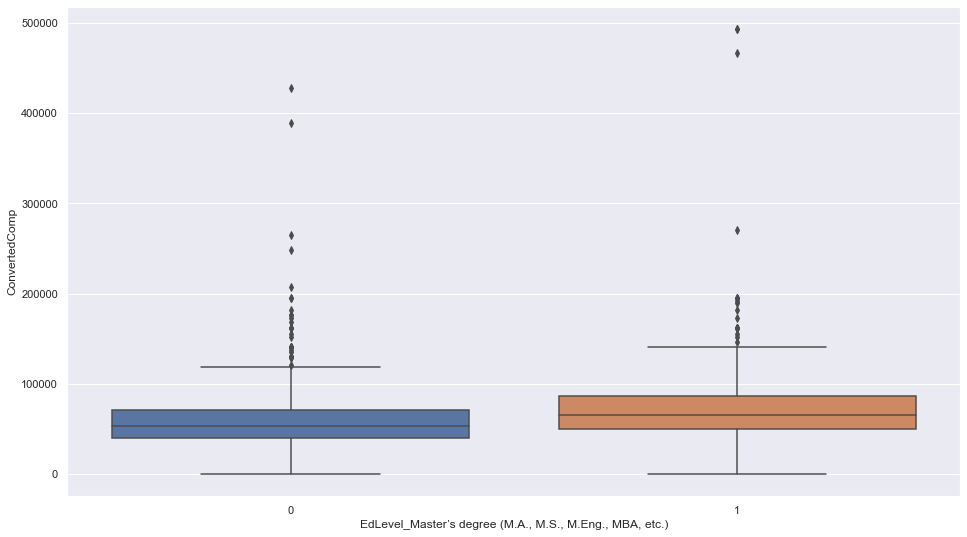

In [81]:
a = data[["ConvertedComp", "EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)", "Country_Netherlands"]].sample(frac=1).reset_index(drop=True)
a = a[a["Country_Netherlands"] == 1]
a = a[a.ConvertedComp <= 500000]
sns.boxplot(x="EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)", y="ConvertedComp", data=a)

In [83]:
data[data["Country_Netherlands"] == 1]["EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)"].value_counts()

0    588
1    222
Name: EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.), dtype: int64

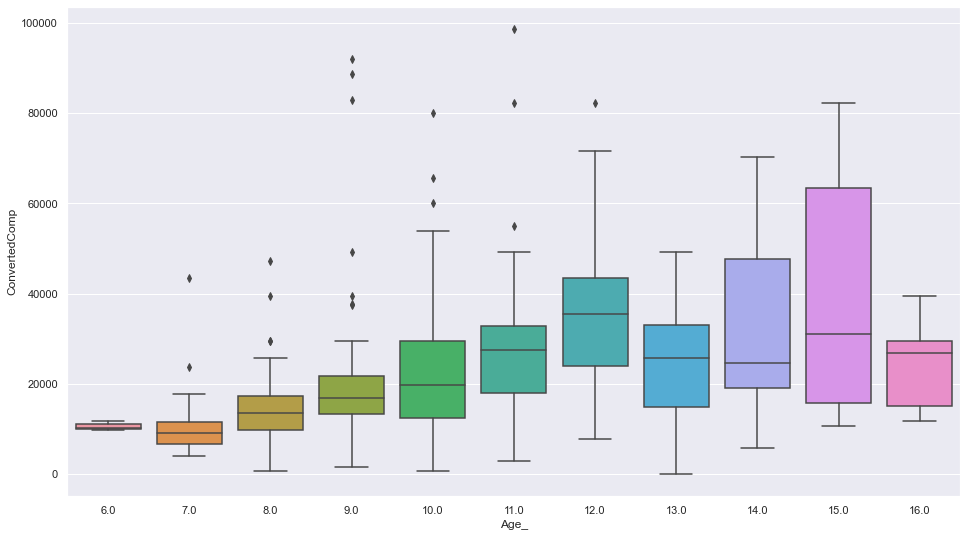

In [72]:
a = data[["ConvertedComp", "Age", "Country_Turkey"]].sample(frac=1).reset_index(drop=True)
a = a[a["Country_Turkey"] == 1]
a = a[a.ConvertedComp <= 100000]
def year_div_10(row):
    row["Age_"] = int(row["Age"] / 3)
    return row
sns.boxplot(x="Age_", y="ConvertedComp", data=a.apply(year_div_10, axis=1))

In [73]:
a[a["Country_Turkey"] == 1].Age.count()

377

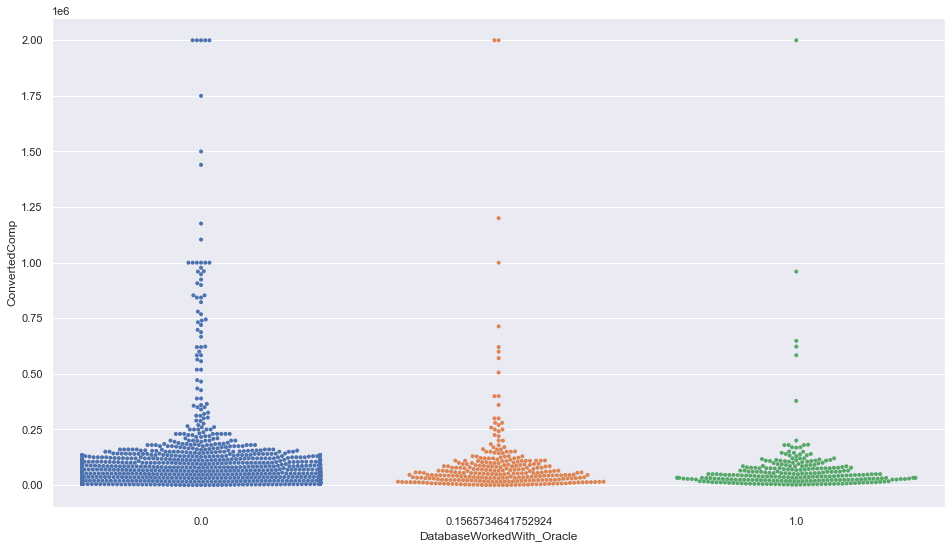

In [58]:
sns.swarmplot(x="DatabaseWorkedWith_Oracle", 
              y="ConvertedComp", 
              data=data[["DatabaseWorkedWith_Oracle", "ConvertedComp"]].sample(frac=1).reset_index(drop=True).head(2000),size=4)

In [28]:
data.head(3).T

,7,9,10
Age,36.000000,22.0,23.000000
Age1stCode,12.000000,14.0,13.000000
ConvertedComp,116000.000000,32315.0,40070.000000
DatabaseDesireNextYear_Cassandra,0.000000,0.0,0.000000
DatabaseDesireNextYear_Couchbase,0.000000,0.0,0.000000
DatabaseDesireNextYear_DynamoDB,0.000000,0.0,0.000000
DatabaseDesireNextYear_Elasticsearch,0.000000,0.0,0.000000
DatabaseDesireNextYear_Firebase,0.000000,0.0,1.000000
DatabaseDesireNextYear_IBM DB2,0.000000,0.0,0.000000
DatabaseDesireNextYear_MariaDB,0.000000,0.0,0.000000


In [22]:
def prepare_data(data=data, exclude_columns=None, features_to_use=None, apply_x_col=None, columns_to_bin=None):

    
    if exclude_columns is not None and features_to_use is not None:
        raise Exception("exclude_columns and features_to_use cannot be used at the same time.")

    if exclude_columns is not None:
        data = data.drop(exclude_columns, axis=1)

    if features_to_use is not None:
        data = data[features_to_use + ["revenue"]]

    x = data.drop('ConvertedComp', axis=1)
    
    y = data['ConvertedComp']

    if apply_x_col is not None:
        x = x.apply(apply_x_col)
    

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size = 0.25, random_state = 42)

    if columns_to_bin is not None:
        for column in columns_to_bin:
            if column not in x_train.columns: continue
            x_train.loc[:,column], bins_ = pd.qcut(x_train.loc[:,column], q=4,  retbins=True, duplicates="drop")
            x_test.loc[:,column] = pd.cut(x_test.loc[:,column], bins=bins_, )
            
            x_train = pd.get_dummies(x_train)
            x_test = pd.get_dummies(x_test)
    
    return x_train, x_test, y_train, y_test, data

In [23]:
def scale_data(x_train, x_test, scaler=StandardScaler):

    scaler = scaler()
    scaler.fit(x_train)

    x_train_scaled = scaler.transform(x_train)
    x_train_scaled = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)

    x_test_scaled = scaler.transform(x_test)
    x_test_scaled = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)

    x_train_scaled.fillna(x_train_scaled.mean(), inplace=True)
    x_test_scaled.fillna(x_test_scaled.mean(), inplace=True)

    return x_train_scaled, x_test_scaled

In [24]:
def evaluate_regression(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name="", model=None, num_feat=""):   
    return pd.DataFrame.from_records([[
                                       metrics.mean_squared_error(y_true_train, y_pred_train),
                                       metrics.mean_absolute_error(y_true_train, y_pred_train),
                                       metrics.max_error(y_true_train, y_pred_train),
                                       metrics.r2_score(y_true_train, y_pred_train), 
                                      metrics.mean_squared_error(y_true_test, y_pred_test),
                                       metrics.mean_absolute_error(y_true_test, y_pred_test),
                                       metrics.max_error(y_true_test, y_pred_test),
                                       metrics.r2_score(y_true_test, y_pred_test),
                                       model,
                                       num_feat]],
                                     
                                     index=[model_name], 
                                     columns=['mean_squared_error_train', 'mean_absolute_error_train', 'max_error_train', "r2_score_train",
                                              'mean_squared_error_test', 'mean_absolute_error_test', 'max_error_test', "r2_score_test", "model_object", "num_feat"])


In [25]:
def run_models(x_train, x_test, y_train, y_test, feture_elimination_num_feat=None):
        results = pd.DataFrame()
        for model in [linear_model.LinearRegression(), 
                        linear_model.RidgeCV(),
                        linear_model.LassoCV(),
                        svm.LinearSVR(),
                        #svm.SVR(kernel="rbf",),
                        #svm.SVR(kernel="poly"),
                        tree.DecisionTreeRegressor(),
                        RandomForestRegressor()]:
                
                if feture_elimination_num_feat is not None :
                        try:
                                if feture_elimination_num_feat == "auto":
                                        feture_elimination_num_feat = np.linspace(5,len(x_train.columns),5, dtype=int)

                                for n_features_to_select in feture_elimination_num_feat:
                                        model_ = RFE(estimator=model, n_features_to_select=n_features_to_select)
                                        model_.fit(x_train, y_train)
                                        y_train_pred = model_.predict(x_train)
                                        y_test_pred = model_.predict(x_test)

                                        results = results.append(evaluate_regression(y_train, y_train_pred, y_test, y_test_pred,
                                                                model_name=type(model_).__name__, model=model_, num_feat=n_features_to_select))
                                return results
                        except Exception as e:
                            print(e)
                                
                        
               
                model.fit(x_train, y_train)
                
                y_train_pred = model.predict(x_train)
                y_test_pred = model.predict(x_test)

                results = results.append(evaluate_regression(y_train, y_train_pred, y_test, y_test_pred,
                                        model_name=type(model).__name__, model=model, num_feat=len(x_train.columns) ))
        return results


In [26]:
experiment_list = pd.DataFrame()

def run(exclude_columns=None, features_to_use=None, name="", apply_x_col=None, x_train_=None, y_train_=None, columns_to_bin=None, feture_elimination_num_feat=None):
    global experiment_list
    print(name)

    x_train, x_test, y_train, y_test, data = prepare_data(exclude_columns=exclude_columns, 
                                                        features_to_use=features_to_use, 
                                                        apply_x_col=apply_x_col,
                                                        columns_to_bin=columns_to_bin)

    if x_train_ is not None or y_train_ is not None:
        x_train, y_train = x_train_, y_train_

    x_train, x_test = scale_data(x_train, x_test, scaler=StandardScaler)

    results = run_models(x_train, x_test, y_train, y_test, feture_elimination_num_feat=feture_elimination_num_feat)

    print("Min mean_squared_error_test Test",results.sort_values("mean_squared_error_test").iloc[0]["mean_squared_error_test"])

    best_model = results.sort_values("mean_squared_error_test").reset_index().loc[[0], ["mean_squared_error_train", 
                                                                                        "mean_squared_error_test", 
                                                                                        "index",
                                                                                        "num_feat",
                                                                                        "model_object"]].rename({0:name, "index":"model_name"})
    if experiment_list is not None:
        experiment_list = experiment_list.append(best_model)

    return results.sort_values("mean_squared_error_test")

In [27]:
results = run(exclude_columns=None, name="Initial Run")

Initial Run


KeyboardInterrupt: 

In [ ]:
results

In [ ]:
x_train, x_test, y_train, y_test, data = prepare_data()

In [ ]:
x_train

In [ ]:
# All Features
x_train.columns.to_list()

In [ ]:
y_test.mean()

In [ ]:
float(7.917081e+04)

In [ ]:
results = run(exclude_columns=None, name="Initial Run",feture_elimination_num_feat="auto")